# Introducere Google Colaboratory & TensorFlow


Scopul acestui laborator este de a introduce unele concepte de bază [TensorFlow](https://www.tensorflow.org/), [Python](https://www.python.org/) și [Jupyter Notebook](https://jupyter.org/), precum și concepte din algebră liniară, Învățare Automată și clasificare, prin implementarea unui model liniar simplu. Folosind setul de date [MNIST](http://yann.lecun.com/exdb/mnist/) cu imagini conținând cifre scrise manual, vom defini și optimiza în TensorFlow un model matematic simplu. Rezultatele vor fi afișate și discutate.

## Imports

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix    # https://en.wikipedia.org/wiki/Confusion_matrix

Vizualizare versiune TensorFlow:

In [2]:
tf.__version__

'1.13.1'

## Load Data

In [0]:
mnist = tf.keras.datasets.mnist

Setul de date MNIST conține 70.000 de imagini și adnotări (clase) pentru imagini. Imaginile sunt împărțite în 2 sub-seturi mutual exclusive, unul folosit pentru antrenare iar celălalt pentru testare.

In [4]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train_flat = np.array([x.flatten() for x in x_train])
x_test_flat = np.array([x.flatten() for x in x_test])

print("Dimensiunea:")
print("- Setului de antrenare:\t\t{}".format(y_train.shape[0]))
print("- Setului de test:\t\t{}".format(y_test.shape[0]))
print("- Unei imagini:\t\t\t{}".format(x_train.shape[1:]))

11493376/11490434 [==============================] - 0s 0us/step
Dimensiunea:
- Setului de antrenare:		60000
- Setului de test:		10000
- Unei imagini:			(28, 28)


In [0]:
# dimensiunea setului de antrenare
num_images = x_train.shape[0]

# dimensiunea imaginilor (înălțime x lățime)
img_shape = x_train.shape[1:]

# dimensiunea imaginilor în formă vectorizată
img_size_flat = x_train_flat.shape[-1]

# numărul de clase
num_classes = np.unique(y_train).size

### Encodarea One-Hot

Clasele imaginilor sunt reprezentate de întregi, fiecare număr întreg semnificând indexul unei clase. În probleme de clasificare, însă, este nevoie ca valorile claselor să fie encodate One-Hot, adică fiecare întreg este convertit într-un vector a cărui lungime este egală cu numărul de clase. Toate elementele vectorului sunt $0$ cu excepția elementului $i$ care este $1$, semnificând faptul că exemplul respectiv aparține clasei $i$.

In [0]:
y_train_one_hot = np.eye(num_classes)[y_train]
y_test_one_hot = np.eye(num_classes)[y_test]

### Funcție ajutătoare pentru afișarea imaginilor.

Funcție pentru afișarea a 9 imagini într-un grid 3x3 și a claselor corecte și prezise pentru fiecare imagine.

In [0]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Afișează imagine.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Arată clasele corecte și prezise.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

### Afișează câteva imagini pentru a verifica corectitudinea datelor.

In [0]:
# Get the first images from the test-set.
images = x_test[0:9]

# Get the true classes for those images.
cls_true = y_test[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

## [Graful TensorFlow](https://www.tensorflow.org/guide/graphs)

Scopul general al TensorFlow este de a avea un așa-numit graf computațional care poate fi executat mult mai eficient decât dacă aceleași operații ar fi executate direct în Python. TensorFlow poate fi mai eficient și decât [NumPy](http://www.numpy.org/) pentru că TensorFlow cunoaște întregul graf computațional care trebuie executat, în timp ce NumPy cunoaște doar o singură operație matematică la un moment dat.

TensorFlow poate, de asemenea, să calculeze automat gradienții necesari pentru optimizarea variabilelor grafului, astfel încât modelul să performeze mai bine. Acest lucru se datorează faptului că graful este o combinație de expresii matematice simple, astfel că gradientul întregului graf poate fi calculat folosind regula înlănțuirii pentru derivate.

TensorFlow poate, de asemenea, să beneficieze de avantajul arhitecturilor multi-CPU și GPU iar Google chiar a construit arhitecturi speciale pentru TensorFlow ([TPU](https://cloud.google.com/tpu/) - Tensor Processing Units) care sunt chiar mai rapide decât GPU-urile.

Un graf TensorFlow conține următoarele părți:

* variabile de tip [Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)  folosite pentru a specifica input-ul în graf.
* [variabilele modelului](https://www.tensorflow.org/guide/variables) care vor fi optimizate pentru a face modelul să performeze mai bine.
* modelul care este, în esență, doar o funcție matematică care calculează un rezultat pe baza input-ului din variabilele placeholder și a variabilelor modelului.
* o [funcție de cost](https://www.tensorflow.org/api_docs/python/tf/losses) folosită pentru a "ghida" optimizarea variabilelor.
* o [metodă de optimizare](https://www.tensorflow.org/api_docs/python/tf/train) care actualizează variabilele modelului.

În plus, graful TensorFlow mai poate conține diverse informații pentru debug, care pot fi afișate în [TensorBoard](https://www.tensorflow.org/guide/summaries_and_tensorboard).

### [Variabile Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)

Variabilele Placeholder servesc ca input în graf și pot fi schimbate de fiecare dată când executăm graful. 

Mai întâi definim variabila Placeholder pentru imaginile de input. Asta ne permite să schimbăm imaginile pe care le vom trimite grafului TensorFlow. Aceasta este un așa-numit [tensor](https://en.wikipedia.org/wiki/Tensor) care este doar un vector multi-dimensional sau o matrice. Tipul de date este `float32` iar forma tensorului este `[None, img_size_flat]`, unde `None` semnifică faptul că tensorul poate conține un număr arbitrar de imagini, fiecare imagine fiind un vector de lungime `img_size_flat`.

In [0]:
x = tf.placeholder(tf.float32, [None, img_size_flat])

În continuare definim variabila placeholder pentru clasele corecte encodate one-hot, asociate imaginilor date ca input în variabila `x` definită anterior. Forma acestui tensor este `[None, num_classes]`, semnificând faptul că poate conține un număr arbitrar de exemple, fiecare fiind un vector de lungime `num_classes`, care este 10 în acest caz.

In [0]:
y_true = tf.placeholder(tf.float32, [None, num_classes])

În final definim variabila placeholder pentru clasa corectă a fiecărei imagini din placeholder-ul `x`. Acestea sunt numere întregi iar dimensiunea tensorului este `[None]`, semnificând faptul că tensorul este un vector uni-dimensional de lungime arbitrară.

In [0]:
y_true_cls = tf.placeholder(tf.int64, [None])

### Variabile ce vor fi optimizate

Pe lângă variabilele placeholder definite anterior și care servesc ca input către model, există și variabile ale modelului propriu-zis care trebuie modificate de către TensorFlow astfel încât modelul să performeze mai bine pe datele de antrenare.

Primele variabile care trebuie optimizate se numesc `ponderi` (`weights`) și le definim aici ca variabile TensorFlow care trebuie inițializate cu zero și a căror formă este `[img_size_flat, num_classes]`, deci sunt un tensor bi-dimensional (matrice) cu `img_size_flat` rânduri și `num_classes` coloane.

In [11]:
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))

Instructions for updating:
Colocations handled automatically by placer.


Celelalte variabile care trebuie optimizate se numesc `bias` și sunt definite ca un tensor uni-dimensional (vector) de lungime `num_classes`.

In [0]:
biases = tf.Variable(tf.zeros([num_classes]))

### Modelul

Acest model matematic simplu multiplică imaginile din placeholderul `x` cu `weights` după care adaugă `biases`.

Rezultatul este o matrice de forma `[num_images, num_classes]` pentru că `x` are forma `[num_images, img_size_flat]` iar `weights` are forma `[img_size_flat, num_classes]`, astfel înmulțirea celor două matrice este o matrice de forma `[num_images, num_classes]` și apoi vectorul `biases` este însumat fiecărui rând din matrice.

Denumirea de `logits` face parte din terminologia tipică TensorFlow, dar utilizatorii pot denumi variabila și în alte moduri.

In [0]:
logits = tf.matmul(x, weights) + biases

`logits` este o matrice cu `num_images` rânduri și `num_classes` coloane, unde elementul de pe rândul $i$ și coloana $j$ este o estimare a probabilității ca imaginea $i$ să aparțină clasei $j$.

Însă aceste estimări sunt dificil de interpretat pentru că numerele pot fi foarte mici sau mari, astfel că dorim să le normalizăm astfel încât fiecare rând din `logits` însumează $1$, iar fiecare element este între $0$ și $1$. Aceasta se face folosind așa-numita funcție [`softmax`](https://en.wikipedia.org/wiki/Softmax_function), iar rezultatul este păstrat în `y_pred`.

In [0]:
y_pred = tf.nn.softmax(logits)

Clasa prezisă poate fi calculată din `y_pred` prin obținerea indexului elementului maxim de pe fiecare rând.

In [0]:
y_pred_cls = tf.argmax(y_pred, axis=1)

### Funcția de cost

Pentru a îmbunătăți modelul în clasificarea imaginilor de input, trebuie să modificăm cumva variabilele `weights` și `biases`. Pentru a realiza asta, trebuie să știm cât de bine performează modelul, comparând rezultatul prezis de model `y_pred` cu valorile corecte `y_true`.

[`cross-entropy`](https://en.wikipedia.org/wiki/Cross_entropy) este o măsură a performanței utilizată în clasificare. Este o funcție continuă, pozitivă tot timpul și dacă rezultatele prezise de model se potrivesc exact cu rezultatele corecte, atunci valoarea cross-entropy este $0$. Scopul optimizării este, astfel, minimizarea valorii cross-entropy, să tindă către $0$ prin modificarea variabilelor `weights` și `biases` din model.

TensorFlow conține o funcție pentru calcularea cross-entropy. Observați că folosește valorile din `logits` pentru că intern calculează și `softmax`.

In [0]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,
                                                           labels=y_true)

Acum am calculat cross-entropy pentru fiecare clasificare de imagine, astfel că avem o măsură a cât de bine performează modelul pe fiecare imagine în parte. Dar pentru a folosi cross-entropy pentru a "ghida" optimizarea variabilelor modelului, avem nevoie de o singură valoare scalară, astfel că pur și simplu vom calcula media valorilor cross-entropy pentru toate clasificările făcute.

In [0]:
cost = tf.reduce_mean(cross_entropy)

### Metoda de optimizare

Acum că avem o măsură a costului care trebuie minimizat, putem defini un optimizator. În acest caz vom folosi [Gradient Descent](https://en.wikipedia.org/wiki/Gradient_descent), cu rata de învățare (`learning_rate`) setată la $0.5$.

Observați că optimizarea nu se execută în acest past. De fapt, nimic nu este calculat până acum, doar au fost adaugate în graful TensorFlow pentru a fi executate mai târziu.

In [0]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

### Măsuri ale performanței

Avem nevoie de câteva măsuri de performanță pentru a fi afișate utilizatorului.

Acesta este un vector de `bool` care specifică dacă clasa prezisă coincide cu cea reală.

In [0]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

Aceasta calculează acuratețea clasificării, prin convertirea vectorului la float, astfel că False devine 0, iar True devine 1, după care se calculează media acestor numere.

In [0]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TensorFlow Run

### Crearea Sesiunii TensorFlow

După ce graful TensorFlow a fost finalizat, trebuie să creăm o sesiune TensorFlow pentru a executa graful.

In [0]:
session = tf.Session()

### Inițializarea variabilelor

Variabilele `weights` și `biases` trebuie inițializate înainte de a le optimiza.

In [0]:
session.run(tf.global_variables_initializer())

### Funcție ajutătoare pentru a realiza optimizarea

Sunt 60.000 de imagini în setul de antrenare, astfel că durează mult să calculăm gradientul modelului folosind întreg setul. Așadar vom folosi [Stochastic Gradient Descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) care folosește doar un mic sub-set de imagini la fiecare iterație a optimizatorului

In [0]:
batch_size = 100

Funcție pentru a realiza un număr de iterații de optimizare astfel încât să îmbunătățim gradual variabilele `weights` și `biases`. În fiecare iterație, un nou sub-set de imagini este selectat din setul de antrenare iar TensorFlow execută optimizarea folosind sub-setul respectiv.

In [0]:
indices = np.arange(num_images)

def optimize(num_iterations):
    for i in range(num_iterations):
        # Obține un subset de exemple de antrenare
        # x_batch conține subsetul de imagini
        # y_true_batch conține subsetul de clase.
        batch_indices = np.random.choice(indices, batch_size)
        x_batch = x_train_flat[batch_indices]
        y_true_batch = y_train_one_hot[batch_indices]
        
        # Pune subsetul de imagini și clase într-un dicționar
        # cu numele corespunzătoare pentru variabilele placeholder
        # din graful TensorFlow.
        # Observați că placeholderul y_true_cls nu este adăugat
        # în dicționar pentru că nu este folosit în timpul antrenării.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Execută optimizatorul folosind acest subset de exemple.
        # TensorFlow asignează variabilele din dicționarul 
        # feed_dict_train placeholder-elor după care execută optimizatorul.
        session.run(optimizer, feed_dict=feed_dict_train)

### Funcții ajutătoare pentru afișarea performanței

Dicționar cu setul de test pentru a fi folosit ca input în graful TensorFlow. Observați că trebuie să folosim denumirea corectă a variabilelor placeholder din graf.

In [0]:
feed_dict_test = {x: x_test_flat,
                  y_true: y_test_one_hot,
                  y_true_cls: y_test}

Funcție pentru afișarea acurateței clasificării pe setul de test.

In [0]:
def print_accuracy():
    # Folosește TensorFlow pentru a calcula acuratețea.
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # Printează acuratețea
    print("Acuratețea pe setul de test: {0:.1%}".format(acc))

Funcție pentru afișarea [matricei de confuzie](https://en.wikipedia.org/wiki/Confusion_matrix) folosind [scikit-learn](https://scikit-learn.org/stable/).

In [0]:
def print_confusion_matrix():
    
    # Obține clasele prezise pentru setul de test.
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # Obține matricea de confuzie.
    cm = confusion_matrix(y_true=y_test,
                          y_pred=cls_pred)

    # Printează matricea de confuzie.
    print(cm)

    # Afișează matricea de confuzie sub formă de imagine.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    

    plt.show()

Funcție pentru afișarea exemplelor din setul de test care au fost clasificate greșit.

In [0]:
def plot_example_errors():
    # Folosește TensorFlow pentru a obține o listă de valori
    # bool semnificând dacă imaginea a fost clasificată corect
    # și o listă a claselor prezise pentru fiecare imagine.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    incorrect = (correct == False)
    
    # Obține imaginile clasificate greșit.
    images = x_test[incorrect]
    
    # Obține clasele prezise pentru aceste imagini.
    cls_pred = cls_pred[incorrect]

    # Obține clasele corecte pentru aceste imagini.
    cls_true = y_test[incorrect]
    
    # Afișează primele 9 imagini.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### Funcție ajutătoare pentru a afișa ponderile (weights) modelului.

Funcție pentru a afișa ponderile modelului. 10 imagini sunt afișate, câte una penru fiecare clasă pe care modelul este antrenat s-o recunoască.

In [0]:
def plot_weights():
    # Obține valoarea variabilei `weights`
    w = session.run(weights)
    
    # Obține minimul și maximul.
    w_min = np.min(w)
    w_max = np.max(w)

    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        if i<10:
            image = w[:, i].reshape(img_shape)

            ax.set_xlabel("Weights: {0}".format(i))

            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

## Performanța modelului înaintea optimizării acestuia

Acuratețea pe setul de test este 9.8%. Asta pentru că modelul a fost doar inițializat, nu și optimizat, astfel că prezice tot timpul că imaginile fac parte din clasa 0, după cum este demonstrat mai jos, iar 9.8% din imaginile setului de test fac parte din clasa 0.

In [31]:
print_accuracy()

Acuratețea pe setul de test: 9.8%


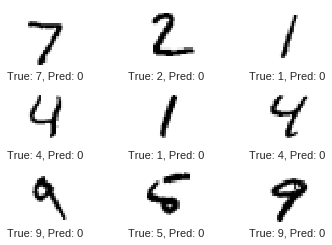

In [32]:
plot_example_errors()

## Performanța modelului după o iterație de optimizare

Deja după o singură iterație de optimizare, acuratețea modelului pe setul de test a crescut semnificativ.

In [0]:
optimize(num_iterations=1)

In [34]:
print_accuracy()

Acuratețea pe setul de test: 29.9%


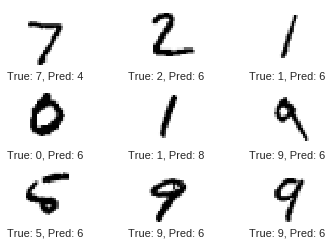

In [35]:
plot_example_errors()

Ponderile modelului pot fi de asemenea afișate. Valorile pozitive sunt cele roșii, iar valorile negative sunt albastre. Astfel, ponderile modelului pot fi înțelese intuitiv ca niște filtre de imagini.

De exemplu, ponderile folosite pentru a stabili dacă o imagine reprezintă un $0$ au valori pozitive distribuite sub forma unui cerc și au valori negative pentru imaginile care au conținut în interiorul cercului respectiv.

Observați că ponderile seamănă în mare parte cu cifrele pe care ar trebui să le recunoască. Asta datorită faptului că s-a efectuat o singură iterație de optimizare, astfel că ponderile au fost antrenate pe doar 100 de imagini. După ce se efectuează mai multe iterații, ponderile devin mai greu de interpretat, pentru că trebuie să recunoască multe variații ale modului în care cifrele pot fi scrise.

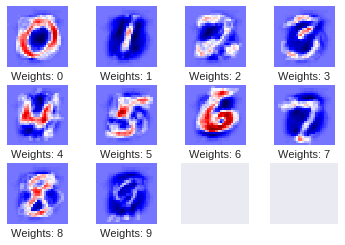

In [37]:
plot_weights()

## Performanța modelului după 10 iterații

In [0]:
# Am efectuat deja o iterație.
optimize(num_iterations=9)

In [39]:
print_accuracy()

Acuratețea pe setul de test: 74.6%


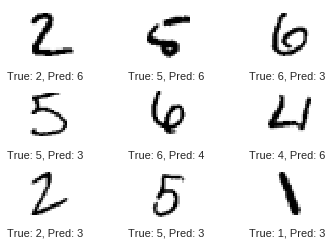

In [40]:
plot_example_errors()

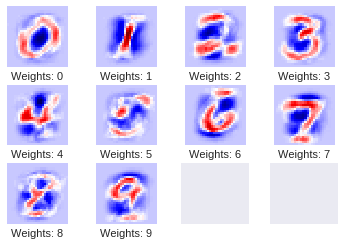

In [41]:
plot_weights()

## Performanța după 1000 de iterații

După 1000 de iterații, modelul greștește aproximativ 1 din 10 imagini. După cum se poate vedea mai jos, unele dintre exemplele greșit clasificate sunt foarte grele chiar și pentru oameni, în timp ce altele sunt destul de evidete și ar fi trebui să fie clasificate corect de un model bun. Dar acest model simplu nu poate performa mai bine de atât, astfel că sunt necesare modele mai complexe.

In [0]:
# Am efectuat deja 10 iterații.
optimize(num_iterations=990)

In [43]:
print_accuracy()

Acuratețea pe setul de test: 91.8%


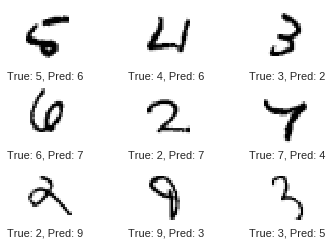

In [44]:
plot_example_errors()

Modelul a fost antrenat timp de 1000 de iterații, fiecare iterație folosinf 100 de imagini din setul de antrenare. Datorită varietății mari de imagini, ponderile modelului sunt acum greu de interpretat și ne putem îndoi dacă modelul înțelege cu adevărat cum cifrele sunt compuse din linii, dau dacă modelul doar a memorat multe variații ale pixelilor.

In [0]:
plot_weights()

Putem, de asemenea, afișa matricea de confuzie care ne permite să observăm mai multe detalii despre exemplele clasificate greșit. De exemplu, se poate observa că imagini reprezentând cifra $5$ au fost de cele mai multe ori clasificare greșit ca fiind $3$,  $6$ sau $8$.

In [0]:
print_confusion_matrix()

Închidem sesiunea pentru a elibera resursele.

In [0]:
session.close()

## Exerciții

Câteva exerciții care vă pot ajuta pentru a vă îmbunătăți înțelegerea TensorFlow. Este important să căpătați cât mai multă experiență practică cu TensorFlow pentru a învăța cum să-l utilizați corespunzător.

Realizați o copie a acestui Notebook înainte de a face modificări.

 

1. Schimbați rata de învățare a optimizatorului.
2. Modificați optimizatorul (de exemplu `AdagradOptimizer` sau . `AdamOptimizer`).
3. Modificați `batch_size` (de exemplu setați la 1 sau 1000).
4. Cum afectează aceste schimbări performanța?
5. Credeți că aceste schimbări vor avea același efect și pentru alte probleme de clasificare și modele matematice?
6. Obțineți aceleași rezultate dacă rulați Notebook-ul de mai multe ori fără să schimbați vreun parametru? De ce/De ce nu? 
7. Modificați funcția `plot_example_errors()` astfel încât să afișeze `logits` și `y_pred` pentru exemplele clasificate greșit.
8. Înlocuiți `softmax_cross_entropy_with_logits` cu `sparse_softmax_cross_entropy_with_logits` în locul. Aceasta poate presupune modificări în mai multe locuri. Discutați avantajele și dezavantajele utilizării celor două metode.
9. Rescrieți programul fără a vă uita prea mult la acest exemplu.
10. Explicați unui prieten cu funcționează programul.